In [3]:
import sys
sys.path.append('/Users/clancy/repos/meg')
#import mpld3

#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d
from numpy.linalg import norm
from dipole_class import DipoleLocalizer
from data_generator_class import DataGenerator
import numpy.random as RA
import numpy.linalg as LA
import scipy.linalg as sciLA
import importlib

# set up configuration file. 
# Note: config files describe mesh to be used, for instance, a one layer spherical mesh, cartesian over a volumne etc,
#config_file = "configs/beamformer_test_spherical_mesh.yaml"
config_file = "configs/beamformer_test.yaml"

# initialize dipole with config file
dip_loc = DipoleLocalizer(config_file)  

# reset number of sensors
#settings = dip_loc.settings
#settings['sensors']['num_sensors'] = 20

nsensors = dip_loc.sensors.shape[0]

# select number of sources to use
ndips = 3

# fix number of time steps
ntimes = 1000
#np.random.seed(1)

# take mesh
mymesh = dip_loc.mesh
sensors = dip_loc.sensors
sensor_dirs = dip_loc.sensor_directions

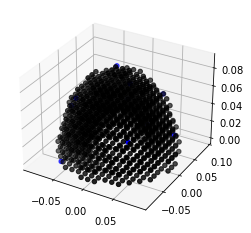

In [4]:
# plot mesh points we are using (we will want to expand this to a general volume, not a shell)
fig = plt.figure();
ax = fig.add_subplot(1,1,1, projection='3d');
scat = ax.scatter(mymesh[:,0], mymesh[:,1], mymesh[:,2], label='True dipole', color='k');
scat = ax.scatter(sensors[:,0], sensors[:,1], sensors[:,2], label='Sensors', color='b');

In [5]:
data_gen = DataGenerator(dip_loc)    
p, q = data_gen.get_random_unit_dipole(.063, .064)
A = dip_loc.lead_field_obj.get_lead_field(p) 
FL = dip_loc.lead_field_obj.get_full_lead_field(p)
sensor_dir = dip_loc.sensor_directions
sensors = dip_loc.sensors

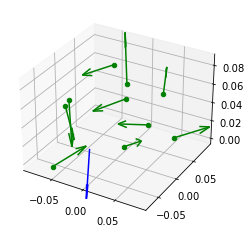

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

AA = np.zeros(sensors.shape)
for i in range(0, FL.shape[0], 3):
    temp = FL[i:i+3,:]
    #d = sensor_dirs[i//3,:]
    s = sensors[i//3,:]
    d = temp@q
    AA[i//3,:] = d
    c = d/norm(d)
    
    

    scat = ax.scatter(s[0], s[1], s[2], label='Fine estimate dipole', color='g')
    scat = ax.quiver(s[0], s[1], s[2], c[0], c[1], c[2], length=.05, color='g')#5e12*norm(d), color='k')
scat = ax.quiver(p[0], p[1], p[2], q[0], q[1], q[2], length=.05, color='b')

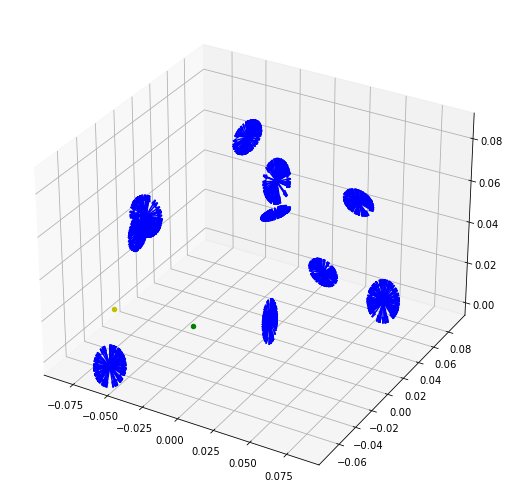

In [7]:
# take any lead field then randomly draw many dipoles. There should be 
# a direction that the B-field cannot span because of the rank deficiency in
# the lead field matrix. This will be based on the orientation of the dipole. 
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1, projection='3d')
scat = ax.scatter(p[0], p[1], p[2], label='Fine estimate dipole', color='g')


leng = .01
#"""
for i in range(len(FL)//3):
    M = FL[3*i:3*(i+1),:]
    loc = sensors[i]
    for i in range(100):
        q = RA.randn(3)
        q /= norm(q)
        b = M@q
        b /= norm(b)
        scat = ax.quiver(loc[0], loc[1], loc[2], b[0], b[1], b[2], length=leng, color='b')

strt = 9
endt = 10
scat = ax.scatter(dip_loc.mesh[strt:endt,0], dip_loc.mesh[strt:endt,1], dip_loc.mesh[strt:endt,2], color='y')

In [8]:
data_gen = DataGenerator(dip_loc)

Ptrue = np.zeros((ndips, 3))
Qtrue = np.zeros((ndips, 3))
A = np.zeros((nsensors, ndips))

for i in range(ndips):
    # choosing inner and outer radius values based on the location of the mesh    
    p, q = data_gen.get_random_unit_dipole(.063, .064)
    A[:,i] = dip_loc.lead_field_obj.get_lead_field(p)@q    
    Ptrue[i,:] = p
    Qtrue[i,:] = q

print('Ptrue')
print(Ptrue)
print('Qtrue')
print(Qtrue)

S = RA.randn(ntimes,ndips)          # initialize source signal to be random (will need to change this)
Q, R = LA.qr(S, mode='reduced')     # orthogonalize the source signal to be random
S = Q.T                             # transpose for the right dimensions
Yclean = 1e6*A@S                             # generate sensors readings based on the lead fields
stdY = np.average(np.std(Yclean, axis=1))
noise = RA.normal(0,.1*stdY, Yclean.shape)
Y = Yclean + noise

ret = dip_loc.localize_multiple_sources(Y, ndips, method='beamformer', localizer='ag')



Ptrue
[[ 0.0061581  -0.03007531  0.05580809]
 [ 0.00206993 -0.01465616  0.06150976]
 [ 0.03252066 -0.04582052  0.03000125]]
Qtrue
[[-0.86457893 -0.47597181 -0.16110279]
 [ 0.11547496  0.96712885  0.22655535]
 [ 0.14466177 -0.46811021 -0.8717487 ]]
Calculating lead fields...this might take a little while
0. p_est [-0.0111475 -0.0111475  0.0780325]
0. q_est [-0.1435621  -0.97661749 -0.16002566]
1. p_est [ 0.04459   -0.022295   0.0557375]
1. q_est [-0.61045417 -0.77137034  0.1798152 ]
2. p_est [ 0.022295 -0.04459   0.04459 ]
2. q_est [-0.79198756  0.18563716  0.58163094]


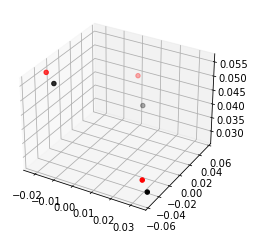

In [7]:
fig = plt.figure()
Psol = dip_loc.multi_crs_dip_loc

ax = fig.add_subplot(1,1,1, projection='3d')
scat = ax.scatter(Ptrue[:,0], Ptrue[:,1], Ptrue[:,2], label='True dipole', color='k')

scat = ax.scatter(Psol[:,0], Psol[:,1], Psol[:,2], label='True dipole', color='r')

#sens = dip_loc.sensors 
#scat = ax.scatter(sens[:,0], sens[:,1], sens[:,2], label='True dipole', color='g')

In [8]:
norm(Psol-Ptrue,axis=1)
import copy
temp = copy.copy(Ptrue)
for p in Psol:
    diffnorms = norm(temp-np.tile(p, (temp.shape[0],1)), axis=1)
    #print(diffnorms)
    idx = np.argmin(diffnorms)
    #print(idx)
    #if isinstance(diffnorms, np.ndarray):
    print("Location error", diffnorms[idx])
    #else:
    #    print("Location error", diffnorms)
    temp = np.delete(temp, idx, axis=0)
    
    

Location error 0.005627001246855294
Location error 0.01080339615928425
Location error 0.011045722562879926
